In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2/*.txt')
files_nm = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2/*nm*.txt')

#here is where the output will go 
path_save_1 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Curve_HANNA_IRON_RERUN_10-02-2023_RUN_2.csv'
path_save_2 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023_RUN_2.csv'
files

['../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_post_Absorbance_0001.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_post_Absorbance_0002.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_post_Absorbance_0003.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_pre_Absorbance_0001.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_pre_Absorbance_0002.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\000_nm_pre_Absorbance_0003.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\010_nm_post_Absorbance_0001.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/RUN_2\\010_nm_post_Absorbance_0002.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/H

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_3820\1438546560.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wl'] = df.index


In [5]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'Iron')

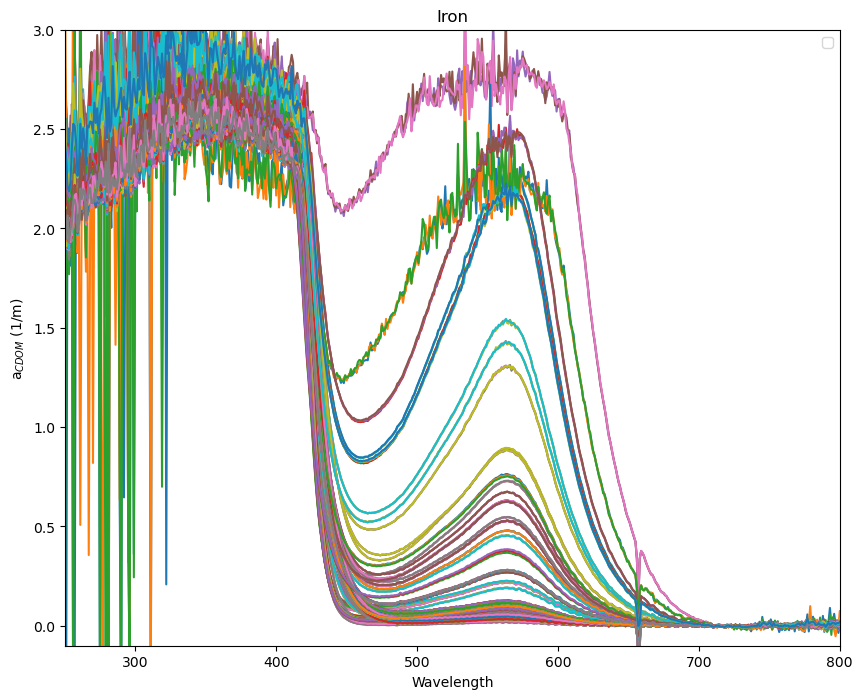

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


Text(0.5, 1.0, 'Iron')

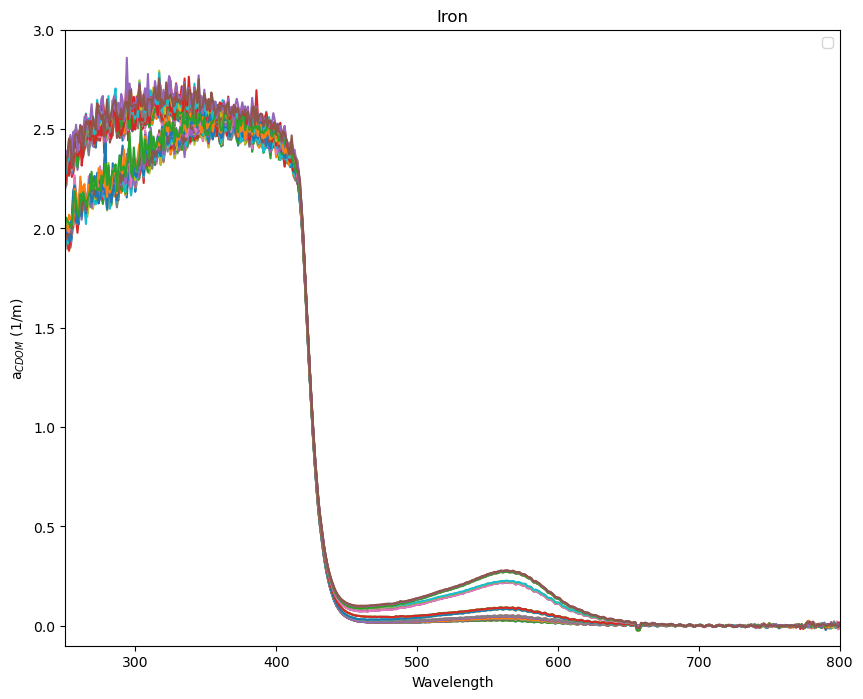

In [7]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df_nm.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


PART 1 
THE CURVE

In [8]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.items():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('_', n=7).str[0]

In [9]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

,abs_562,intagration,conc,ID
sample,,,,
000_nm_post_Absorbance_0001.txt,0.027610,3.694685,0,000
000_nm_post_Absorbance_0002.txt,0.028665,3.957007,0,000
000_nm_post_Absorbance_0003.txt,0.027836,3.722238,0,000
000_nm_pre_Absorbance_0001.txt,0.035204,4.410386,0,000
000_nm_pre_Absorbance_0002.txt,0.033408,4.086750,0,000
000_nm_pre_Absorbance_0003.txt,0.033210,4.057896,0,000
010_nm_post_Absorbance_0001.txt,0.037261,4.356001,10,010
010_nm_post_Absorbance_0002.txt,0.036692,4.338156,10,010
010_nm_post_Absorbance_0003.txt,0.037394,4.385307,10,010


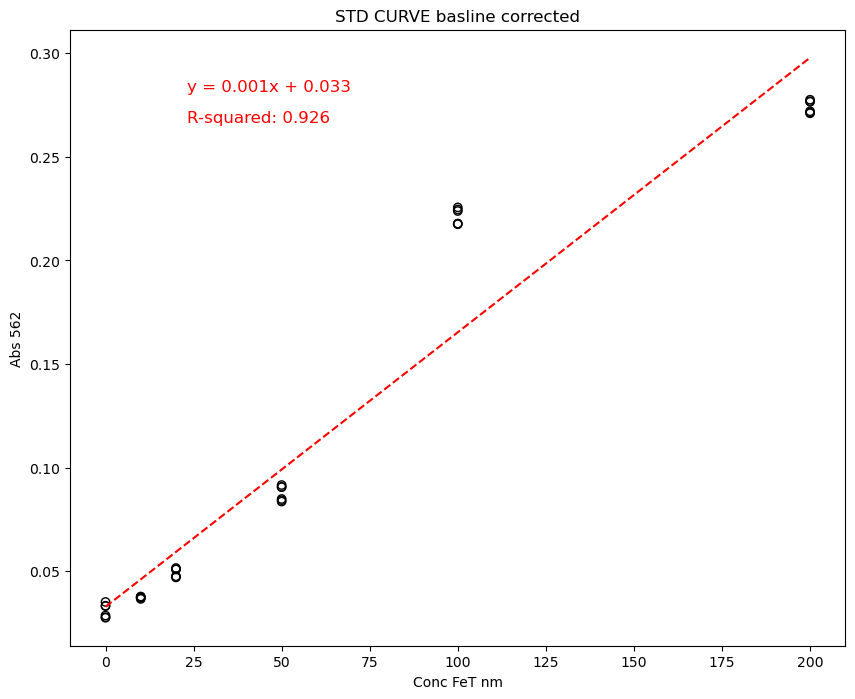

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


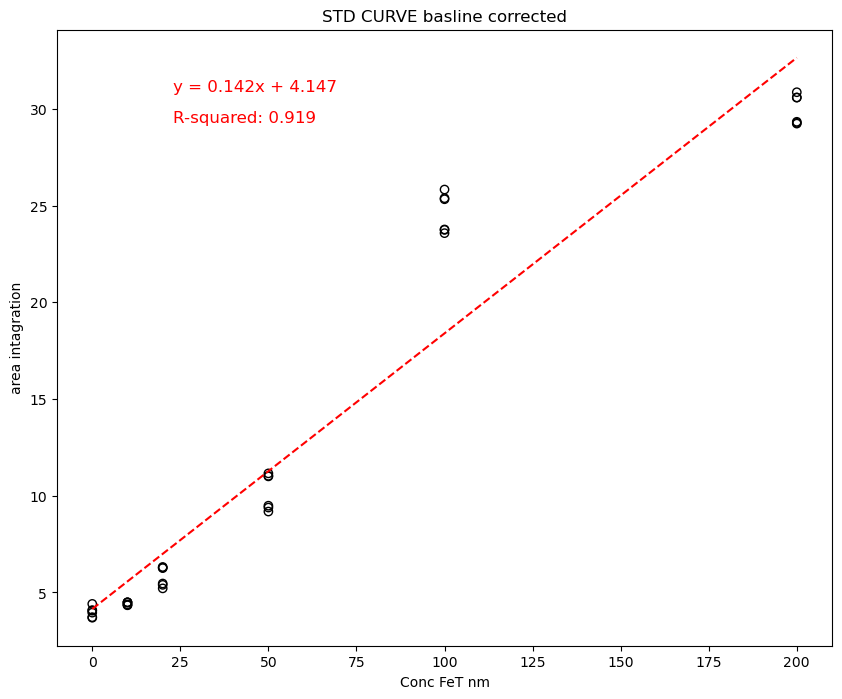

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [12]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


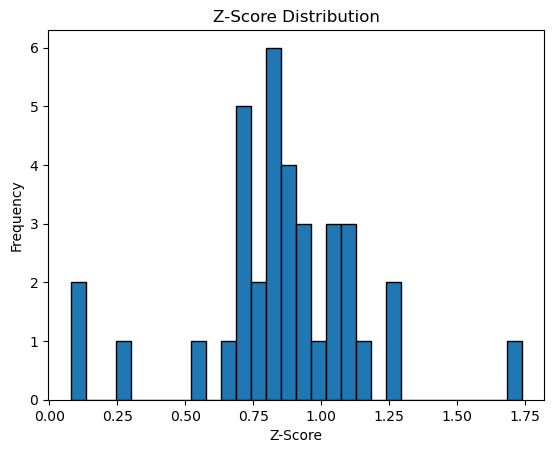

                                  abs_562  intagration  conc   ID      mean  \
sample                                                                        
000_nm_post_Absorbance_0001.txt  0.027610     3.694685     0  000  0.030989   
000_nm_post_Absorbance_0003.txt  0.027836     3.722238     0  000  0.030989   
000_nm_pre_Absorbance_0001.txt   0.035204     4.410386     0  000  0.030989   
010_nm_post_Absorbance_0002.txt  0.036692     4.338156    10  010  0.037358   
010_nm_pre_Absorbance_0002.txt   0.037842     4.485328    10  010  0.037358   
020_nm_post_Absorbance_0003.txt  0.047042     5.211259    20  020  0.049267   
020_nm_pre_Absorbance_0003.txt   0.051580     6.260584    20  020  0.049267   
050_nm_post_Absorbance_0001.txt  0.083649     9.182829    50  050  0.087627   
050_nm_post_Absorbance_0003.txt  0.084256     9.389034    50  050  0.087627   
050_nm_pre_Absorbance_0002.txt   0.091622    11.156128    50  050  0.087627   
100_nm_post_Absorbance_0001.txt  0.217435    23.7645

In [13]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [14]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

Group: 000
Row with highest z_score: 
                                 abs_562  intagration  conc   ID      mean  \
sample                                                                       
000_nm_pre_Absorbance_0001.txt  0.035204     4.410386     0  000  0.030989   

                                     std   z_score  
sample                                              
000_nm_pre_Absorbance_0001.txt  0.003326  1.267383  

Group: 010
Row with highest z_score: 
                                  abs_562  intagration  conc   ID      mean  \
sample                                                                        
010_nm_post_Absorbance_0002.txt  0.036692     4.338156    10  010  0.037358   

                                      std   z_score  
sample                                               
010_nm_post_Absorbance_0002.txt  0.000383  1.737376  

Group: 020
Row with highest z_score: 
                                abs_562  intagration  conc   ID      mean  \
sample       

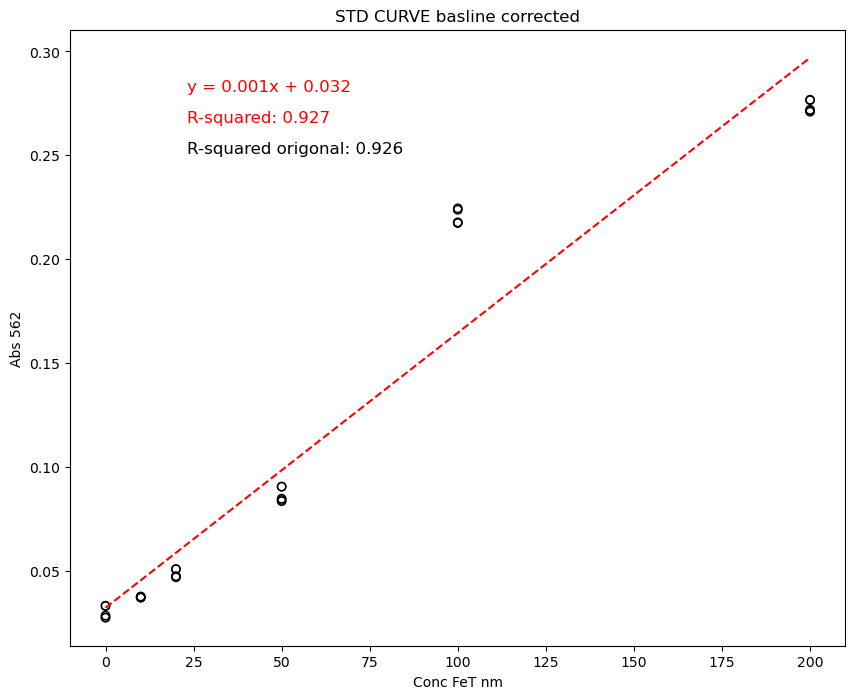

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


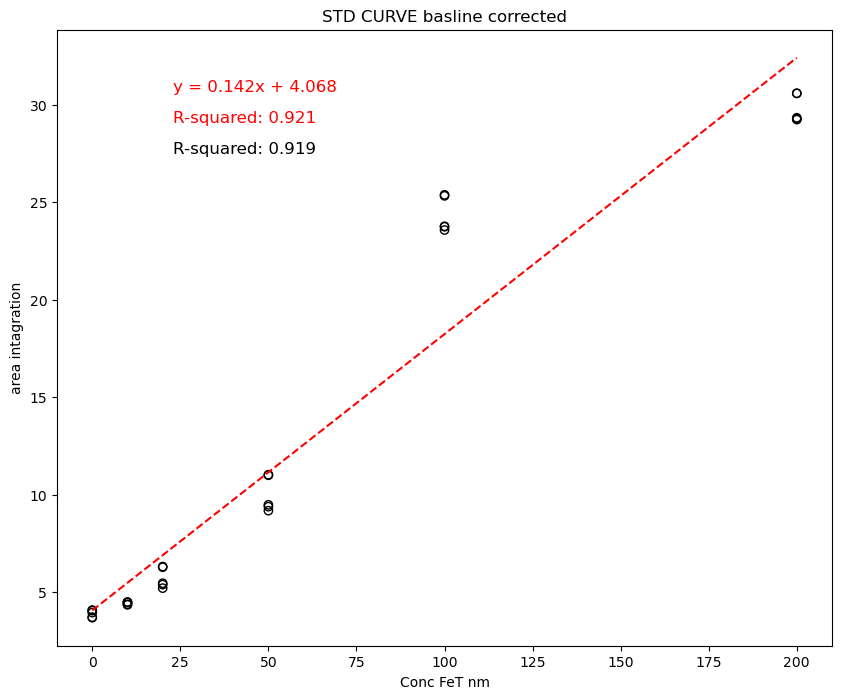

In [16]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [17]:
std_outs

,abs_562,intagration,conc,ID,mean,std,z_score
sample,,,,,,,
000_nm_post_Absorbance_0001.txt,0.027610,3.694685,0,000,0.030989,0.003326,1.016004
000_nm_post_Absorbance_0002.txt,0.028665,3.957007,0,000,0.030989,0.003326,0.698645
000_nm_post_Absorbance_0003.txt,0.027836,3.722238,0,000,0.030989,0.003326,0.947854
000_nm_pre_Absorbance_0002.txt,0.033408,4.086750,0,000,0.030989,0.003326,0.727268
000_nm_pre_Absorbance_0003.txt,0.033210,4.057896,0,000,0.030989,0.003326,0.667853
010_nm_post_Absorbance_0001.txt,0.037261,4.356001,10,010,0.037358,0.000383,0.253979
010_nm_post_Absorbance_0003.txt,0.037394,4.385307,10,010,0.037358,0.000383,0.094380
010_nm_pre_Absorbance_0001.txt,0.037571,4.482046,10,010,0.037358,0.000383,0.555849
010_nm_pre_Absorbance_0002.txt,0.037842,4.485328,10,010,0.037358,0.000383,1.262101


In [18]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('ID', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs.groupby(std_outs['conc']).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

,abs_562,intagration,mean,std,z_score
conc,,,,,
0,0.030146,3.903715,0.030989,0.003326,0.811525
10,0.037491,4.440642,0.037358,0.000383,0.449067
20,0.048805,5.733943,0.049267,0.002113,0.866720
50,0.086829,10.017255,0.087627,0.003717,0.869394
100,0.220252,24.357575,0.221138,0.003885,0.855669
200,0.273522,29.802354,0.274189,0.003055,0.865123


PART 2
THE DATA

In [19]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.items():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

,abs_562,intagration
sample,,
211437_Absorbance_0001.txt,0.041590,6.947349
211437_Absorbance_0002.txt,0.042090,7.349390
211437_Absorbance_0003.txt,0.043667,7.422360
211437_Absorbance_0004.txt,0.044431,7.452827
211437_Absorbance_0005.txt,0.043335,7.305500
...,...,...
MS225037_Absorbance_0002.txt,0.279775,31.785956
MS225037_Absorbance_0003.txt,0.279855,31.829910
MS225338_Absorbance_0001.txt,2.160279,251.953075


In [20]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']

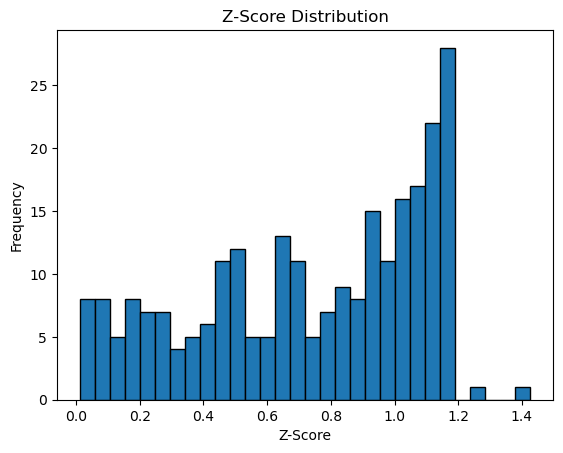

                               abs_562  intagration group_name      mean  \
sample                                                                     
211437_Absorbance_0001.txt    0.041590     6.947349     211437  0.043100   
211437_Absorbance_0002.txt    0.042090     7.349390     211437  0.043100   
211437_Absorbance_0004.txt    0.044431     7.452827     211437  0.043100   
212834_Absorbance_0004.txt    0.071653     9.352537     212834  0.071268   
212834_Absorbance_0006.txt    0.070980     9.433633     212834  0.071268   
...                                ...          ...        ...       ...   
MS224838_Absorbance_0001.txt  0.366852    40.837444   MS224838  0.376460   
MS224838_Absorbance_0003.txt  0.385651    42.800194   MS224838  0.376460   
MS225037_Absorbance_0001.txt  0.278418    31.539510   MS225037  0.279349   
MS225338_Absorbance_0001.txt  2.160279   251.953075   MS225338  2.175754   
MS225338_Absorbance_0002.txt  2.196326   252.739528   MS225338  2.175754   

           

In [21]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [22]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: 211437
Index of row with highest z_score: 
Index(['211437_Absorbance_0001.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
211437_Absorbance_0001.txt    1.426829
211437_Absorbance_0002.txt    0.954635
211437_Absorbance_0003.txt    0.536141
211437_Absorbance_0004.txt    1.258046
211437_Absorbance_0005.txt    0.222033
211437_Absorbance_0006.txt    0.365244
Name: z_score, dtype: float64

Group: 212834
Index of row with highest z_score: 
Index(['212834_Absorbance_0004.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
212834_Absorbance_0004.txt    1.110374
212834_Absorbance_0005.txt    0.280774
212834_Absorbance_0006.txt    0.829600
Name: z_score, dtype: float64

Group: 212836
Index of row with highest z_score: 
Index(['212836_Absorbance_0002.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
212836_Absorbance_0001.txt    0.709194
212836_Absorbance_0002.txt    1.143763
212836_Absorbance_0003.txt    0.434569
Name: z_sco

In [23]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

,abs_562,intagration,mean,std,z_score
group_name,,,,,
211437,0.043402,7.340564,0.043100,0.001058,0.667220
212834,0.071075,9.384621,0.071268,0.000347,0.555187
212836,0.067977,7.511113,0.067836,0.000248,0.571881
212933,0.030981,4.648279,0.030828,0.000267,0.572921
213032,0.028280,4.629917,0.028357,0.000132,0.575921
...,...,...,...,...,...
MS221835,0.100693,12.159745,0.100489,0.000369,0.553349
MS224533,0.098181,12.168710,0.098325,0.000255,0.563598
MS224838,0.381264,42.359002,0.376460,0.009407,0.510739
